In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
import itertools

In [133]:
def load_data(filepath):
    df = pd.read_csv(filepath, index_col=0)
    return df

In [134]:
SIGNAL_CATEGORIES = {
    'ECG_BVP': [
        'HR_mean', 'HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV',
        'LF', 'HF', 'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm'
    ],
    'EDA': [
        'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_range', 'EDA_slope',
        'scl_mean', 'scl_std', 'scr_mean', 'scr_std', 'corr_scl_t',
        'scr_count', 'scr_amp', 'scr_sum', 'scr_area'
    ],
    'EMG': [
        'EMG_mean', 'EMG_std', 'EMG_median', 'EMG_p10', 'EMG_p90', 'EMG_range',
        'EMG_sum', 'EMG_f_peak',
        'EMG_psd_0_10Hz', 'EMG_psd_10_20Hz', 'EMG_psd_20_50Hz',
        'EMG_psd_50_100Hz', 'EMG_psd_100_150Hz', 'EMG_psd_150_250Hz',
        'EMG_psd_250_350Hz',
        'EMG_peak_count', 'EMG_peak_amp_mean', 'EMG_peak_amp_std',
        'EMG_peak_amp_sum', 'EMG_peak_amp_norm'
    ],
    'RESP': [
        'Resp_mean', 'Resp_std', 'Resp_I_mean', 'Resp_I_std',
        'Resp_E_mean', 'Resp_E_std', 'Resp_IE_ratio', 'Resp_range',
        'Resp_insp_vol', 'Resp_rate', 'Resp_duration'
    ],
    'TEMP': [
        'Temp_mean', 'Temp_std', 'Temp_min', 'Temp_max', 'Temp_range', 'Temp_slope'
    ]
}

random = 13577

In [135]:
def calculate_metrics(y_true, y_pred, stage):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    metrics_table = pd.DataFrame({
        "Métrica": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Valor": [accuracy, precision, recall, f1],
        "Etapa": stage
    })
    
    print(f"{stage} Metrics")
    print(metrics_table)
    return metrics_table

In [136]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    print(f"{title} - Confusion Matrix")
    print(conf_mat)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, cmap="Greens", xticklabels=set(y_true), yticklabels=set(y_true), fmt='g')
    plt.xlabel("Etiquetas predichas")
    plt.ylabel("Etiquetas verdaderas")
    plt.title(f'Matriz de confusión - {title}')
    plt.show()

In [137]:
def train_and_evaluate(X, y, model, param_grid, model_name, signal_name):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random, stratify=y)
    
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=16, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]
    
    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_test, y_pred, f'{signal_name} - {model_name}')

    print(classification_report(y_test, y_pred))

    return metrics

In [138]:
def train_and_evaluate_logo(X, y, groups, model, param_grid, model_name, signal_name):
    logo = LeaveOneGroupOut()

    n_splits = logo.get_n_splits(groups=groups)
    print(f"[{signal_name} - {model_name}] LOGO: {n_splits} folds (1 por sujeto)")

    grid_search = GridSearchCV(model, param_grid, cv=logo.split(X, y, groups=groups), n_jobs=16, verbose=1)
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    y_pred = []
    y_true = []

    fold_accuracies = []
    subject_ids = []

    # Evaluamos con LOGO para obtener predicciones fuera de muestra
    for i, (train_idx, test_idx) in enumerate(logo.split(X, y, groups), 1):
        subject_tested = np.unique(groups[test_idx])[0]
        assert len(np.unique(groups[test_idx])) == 1, "Test set debe contener exactamente un sujeto"
        print(f"[{signal_name} - {model_name}] Fold {i}/{n_splits} (Subject: {subject_tested})")

        best_model.fit(X[train_idx], y[train_idx])
        preds = best_model.predict(X[test_idx])

        y_pred.extend(preds)
        y_true.extend(y[test_idx])

        acc_fold = accuracy_score(y[test_idx], preds)
        fold_accuracies.append(acc_fold)
        subject_ids.append(subject_tested)

    # Crear gráfico de accuracy por sujeto
    plt.figure(figsize=(10, 4))
    plt.plot(subject_ids, fold_accuracies, marker='o', linestyle='-')
    plt.xticks(subject_ids)
    plt.title(f'Accuracy por sujeto - {signal_name} - {model_name}')
    plt.xlabel('Sujeto')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    metrics = calculate_metrics(y_true, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]

    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_true, y_pred, f'{signal_name} - {model_name}')
    print(classification_report(y_true, y_pred))

    return metrics

In [139]:
models = {
    "DecisionTree": (
        DecisionTreeClassifier(class_weight='balanced', random_state=random, criterion="entropy", min_samples_split=20),
        {
        }
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight='balanced', random_state=random, criterion='entropy', n_estimators=100, min_samples_split=20),
        {
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=random),
        {
            "n_estimators": [100],
            "learning_rate": [0.01, 0.1, 0.5, 1],
            "estimator": [
                DecisionTreeClassifier(max_depth=1, class_weight='balanced', criterion="entropy", min_samples_split=20)
            ]
        }
    ),
    "LDA": (
        LinearDiscriminantAnalysis(),
        {"solver": ["svd"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "n_neighbors": [9],
            "weights": ["uniform", "distance"]
        }
    )
}

results = {}


all_signals = list(SIGNAL_CATEGORIES.keys())
combinations = []
for r in range(2, len(all_signals) + 1):
    combinations.extend(itertools.combinations(all_signals, r))

In [140]:
file = r'WESAD_DATA_60_025\features.csv'

df = load_data(file)
df = df.fillna(0)

In [141]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 68659
Label: 2 total: 38904
Label: 3 total: 21459


In [142]:
#Aplicar muestra binaria
df['label'] = df['label'].apply(lambda x: 1 if x in [1, 3] else 2)

In [143]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 90118
Label: 2 total: 38904


Training by signal:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ECG_BVP using LOGO...
[ECG_BVP - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ECG_BVP - DecisionTree] Fold 1/15 (Subject: 2)
[ECG_BVP - DecisionTree] Fold 2/15 (Subject: 3)
[ECG_BVP - DecisionTree] Fold 3/15 (Subject: 4)
[ECG_BVP - DecisionTree] Fold 4/15 (Subject: 5)
[ECG_BVP - DecisionTree] Fold 5/15 (Subject: 6)
[ECG_BVP - DecisionTree] Fold 6/15 (Subject: 7)
[ECG_BVP - DecisionTree] Fold 7/15 (Subject: 8)
[ECG_BVP - DecisionTree] Fold 8/15 (Subject: 9)
[ECG_BVP - DecisionTree] Fold 9/15 (Subject: 10)
[ECG_BVP - DecisionTree] Fold 10/15 (Subject: 11)
[ECG_BVP - DecisionTree] Fold 11/15 (Subject: 13)
[ECG_BVP - DecisionTree] Fold 12/15 (Subject: 14)
[ECG_BVP - DecisionTree] Fold 13/15 (Subject: 15)
[ECG_BVP - DecisionTree] Fold 14/15 (Subject: 16)
[ECG_BVP - DecisionTree] Fold 15/15 (Subject: 17)


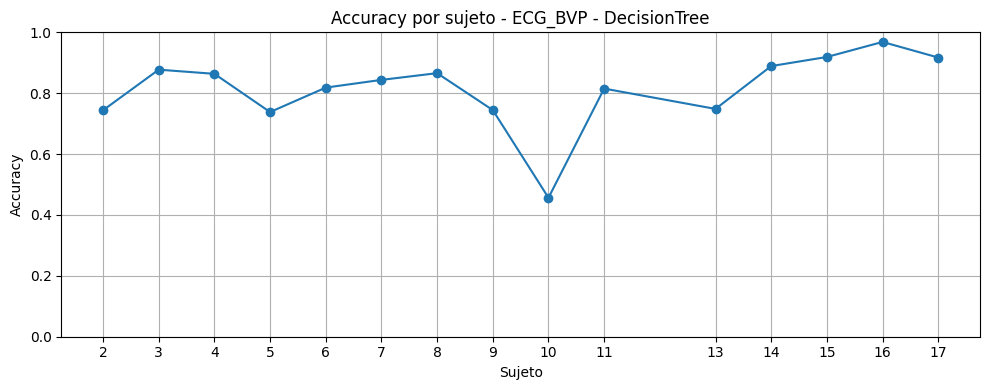

ECG_BVP - DecisionTree Metrics
     Métrica     Valor                   Etapa
0   Accuracy  0.813590  ECG_BVP - DecisionTree
1  Precision  0.817094  ECG_BVP - DecisionTree
2     Recall  0.813590  ECG_BVP - DecisionTree
3   F1 Score  0.815065  ECG_BVP - DecisionTree
[ECG_BVP - DecisionTree] Best Params: {}
[ECG_BVP - DecisionTree] Accuracy: 0.8136
ECG_BVP - DecisionTree - Confusion Matrix
[[76939 13179]
 [10872 28032]]


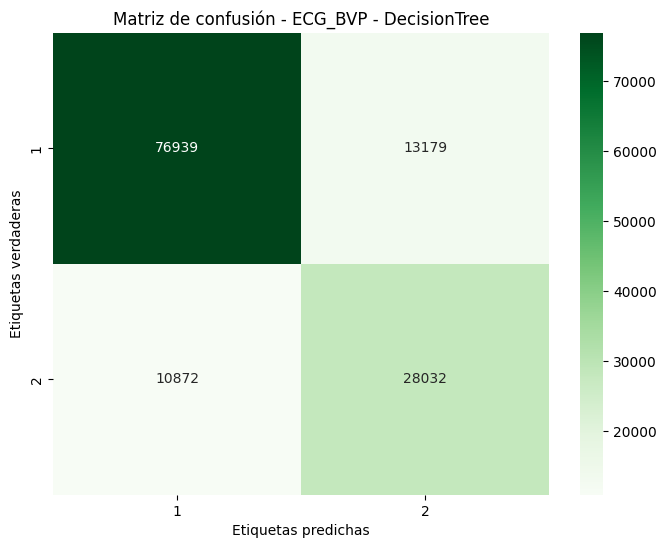

              precision    recall  f1-score   support

           1       0.88      0.85      0.86     90118
           2       0.68      0.72      0.70     38904

    accuracy                           0.81    129022
   macro avg       0.78      0.79      0.78    129022
weighted avg       0.82      0.81      0.82    129022

Training RandomForest model for ECG_BVP using LOGO...
[ECG_BVP - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ECG_BVP - RandomForest] Fold 1/15 (Subject: 2)
[ECG_BVP - RandomForest] Fold 2/15 (Subject: 3)
[ECG_BVP - RandomForest] Fold 3/15 (Subject: 4)
[ECG_BVP - RandomForest] Fold 4/15 (Subject: 5)
[ECG_BVP - RandomForest] Fold 5/15 (Subject: 6)
[ECG_BVP - RandomForest] Fold 6/15 (Subject: 7)
[ECG_BVP - RandomForest] Fold 7/15 (Subject: 8)
[ECG_BVP - RandomForest] Fold 8/15 (Subject: 9)
[ECG_BVP - RandomForest] Fold 9/15 (Subject: 10)
[ECG_BVP - RandomForest] Fold 10/15 (Subject: 11)
[ECG_BVP - RandomFor

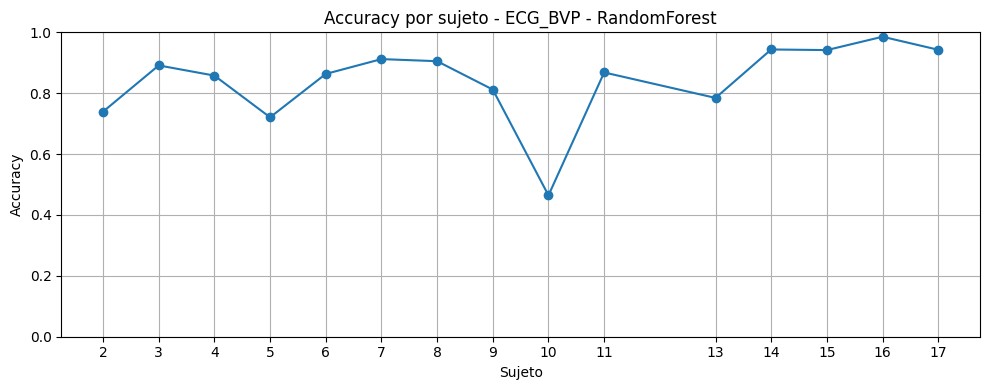

ECG_BVP - RandomForest Metrics
     Métrica     Valor                   Etapa
0   Accuracy  0.841887  ECG_BVP - RandomForest
1  Precision  0.840562  ECG_BVP - RandomForest
2     Recall  0.841887  ECG_BVP - RandomForest
3   F1 Score  0.841135  ECG_BVP - RandomForest
[ECG_BVP - RandomForest] Best Params: {}
[ECG_BVP - RandomForest] Accuracy: 0.8419
ECG_BVP - RandomForest - Confusion Matrix
[[80548  9570]
 [10830 28074]]


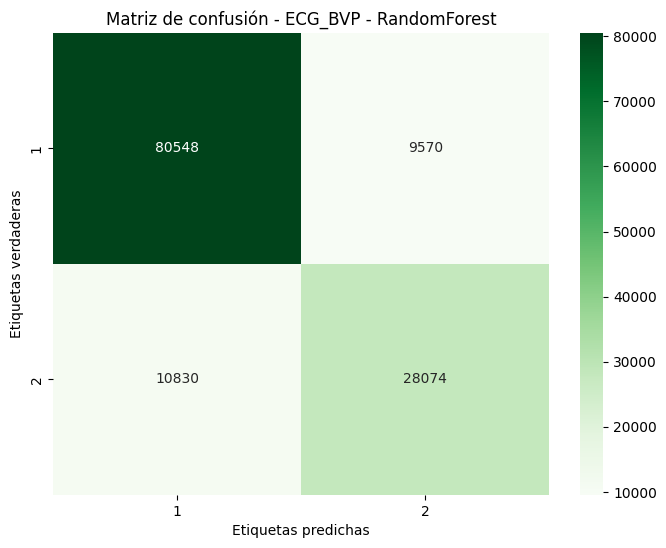

              precision    recall  f1-score   support

           1       0.88      0.89      0.89     90118
           2       0.75      0.72      0.73     38904

    accuracy                           0.84    129022
   macro avg       0.81      0.81      0.81    129022
weighted avg       0.84      0.84      0.84    129022

Training AdaBoost model for ECG_BVP using LOGO...
[ECG_BVP - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[ECG_BVP - AdaBoost] Fold 1/15 (Subject: 2)
[ECG_BVP - AdaBoost] Fold 2/15 (Subject: 3)
[ECG_BVP - AdaBoost] Fold 3/15 (Subject: 4)
[ECG_BVP - AdaBoost] Fold 4/15 (Subject: 5)
[ECG_BVP - AdaBoost] Fold 5/15 (Subject: 6)
[ECG_BVP - AdaBoost] Fold 6/15 (Subject: 7)
[ECG_BVP - AdaBoost] Fold 7/15 (Subject: 8)
[ECG_BVP - AdaBoost] Fold 8/15 (Subject: 9)
[ECG_BVP - AdaBoost] Fold 9/15 (Subject: 10)
[ECG_BVP - AdaBoost] Fold 10/15 (Subject: 11)
[ECG_BVP - AdaBoost] Fold 11/15 (Subject: 13)
[ECG_BVP - AdaBoost] F

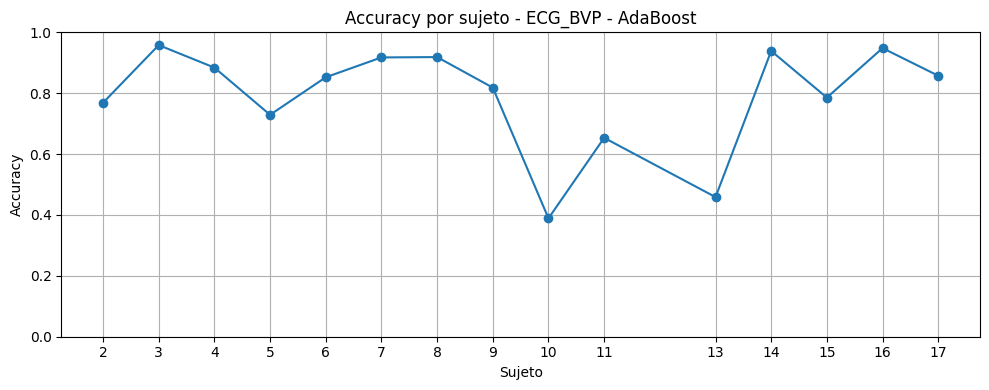

ECG_BVP - AdaBoost Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.790602  ECG_BVP - AdaBoost
1  Precision  0.819998  ECG_BVP - AdaBoost
2     Recall  0.790602  ECG_BVP - AdaBoost
3   F1 Score  0.797422  ECG_BVP - AdaBoost
[ECG_BVP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, min_samples_split=20), 'learning_rate': 0.1, 'n_estimators': 100}
[ECG_BVP - AdaBoost] Accuracy: 0.7906
ECG_BVP - AdaBoost - Confusion Matrix
[[70157 19961]
 [ 7056 31848]]


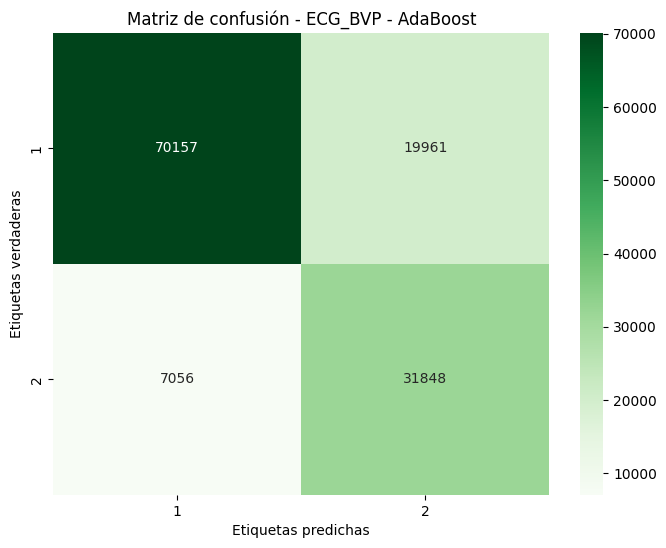

              precision    recall  f1-score   support

           1       0.91      0.78      0.84     90118
           2       0.61      0.82      0.70     38904

    accuracy                           0.79    129022
   macro avg       0.76      0.80      0.77    129022
weighted avg       0.82      0.79      0.80    129022

Training LDA model for ECG_BVP using LOGO...
[ECG_BVP - LDA] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[ECG_BVP - LDA] Fold 1/15 (Subject: 2)
[ECG_BVP - LDA] Fold 2/15 (Subject: 3)
[ECG_BVP - LDA] Fold 3/15 (Subject: 4)
[ECG_BVP - LDA] Fold 4/15 (Subject: 5)
[ECG_BVP - LDA] Fold 5/15 (Subject: 6)
[ECG_BVP - LDA] Fold 6/15 (Subject: 7)
[ECG_BVP - LDA] Fold 7/15 (Subject: 8)
[ECG_BVP - LDA] Fold 8/15 (Subject: 9)
[ECG_BVP - LDA] Fold 9/15 (Subject: 10)
[ECG_BVP - LDA] Fold 10/15 (Subject: 11)
[ECG_BVP - LDA] Fold 11/15 (Subject: 13)
[ECG_BVP - LDA] Fold 12/15 (Subject: 14)
[ECG_BVP - LDA] Fold 13/15 (Subject: 15)
[ECG_

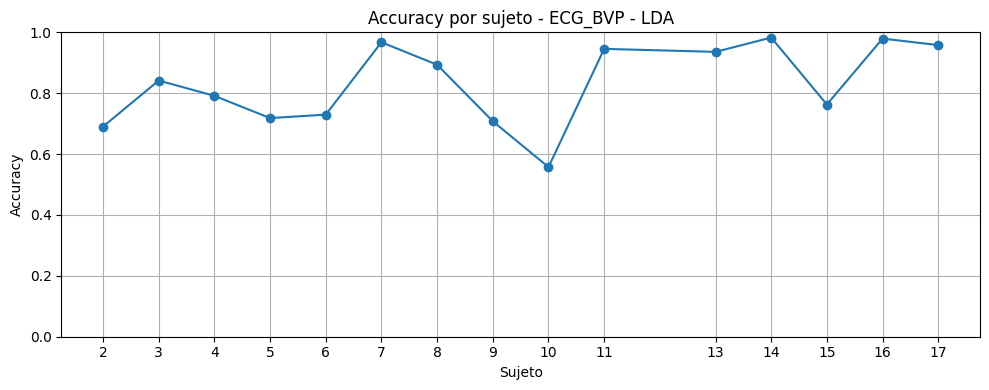

ECG_BVP - LDA Metrics
     Métrica     Valor          Etapa
0   Accuracy  0.831114  ECG_BVP - LDA
1  Precision  0.827553  ECG_BVP - LDA
2     Recall  0.831114  ECG_BVP - LDA
3   F1 Score  0.823184  ECG_BVP - LDA
[ECG_BVP - LDA] Best Params: {'solver': 'svd'}
[ECG_BVP - LDA] Accuracy: 0.8311
ECG_BVP - LDA - Confusion Matrix
[[84181  5937]
 [15853 23051]]


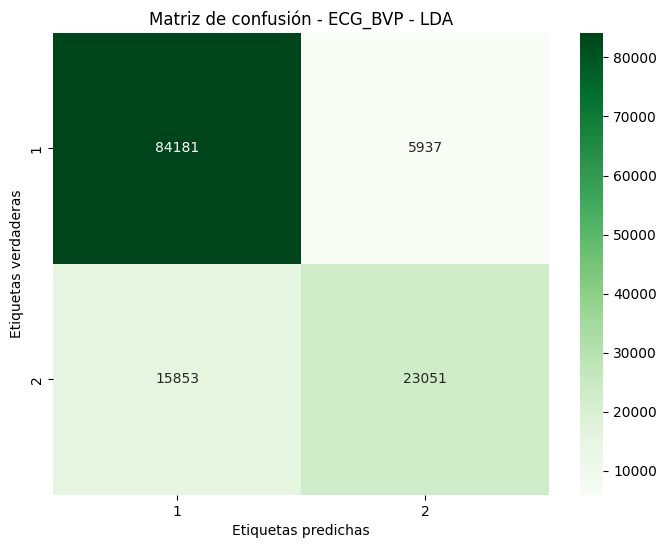

              precision    recall  f1-score   support

           1       0.84      0.93      0.89     90118
           2       0.80      0.59      0.68     38904

    accuracy                           0.83    129022
   macro avg       0.82      0.76      0.78    129022
weighted avg       0.83      0.83      0.82    129022

Training KNN model for ECG_BVP using LOGO...
[ECG_BVP - KNN] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 2 candidates, totalling 30 fits
[ECG_BVP - KNN] Fold 1/15 (Subject: 2)
[ECG_BVP - KNN] Fold 2/15 (Subject: 3)
[ECG_BVP - KNN] Fold 3/15 (Subject: 4)
[ECG_BVP - KNN] Fold 4/15 (Subject: 5)
[ECG_BVP - KNN] Fold 5/15 (Subject: 6)
[ECG_BVP - KNN] Fold 6/15 (Subject: 7)
[ECG_BVP - KNN] Fold 7/15 (Subject: 8)
[ECG_BVP - KNN] Fold 8/15 (Subject: 9)
[ECG_BVP - KNN] Fold 9/15 (Subject: 10)
[ECG_BVP - KNN] Fold 10/15 (Subject: 11)
[ECG_BVP - KNN] Fold 11/15 (Subject: 13)
[ECG_BVP - KNN] Fold 12/15 (Subject: 14)
[ECG_BVP - KNN] Fold 13/15 (Subject: 15)
[ECG_

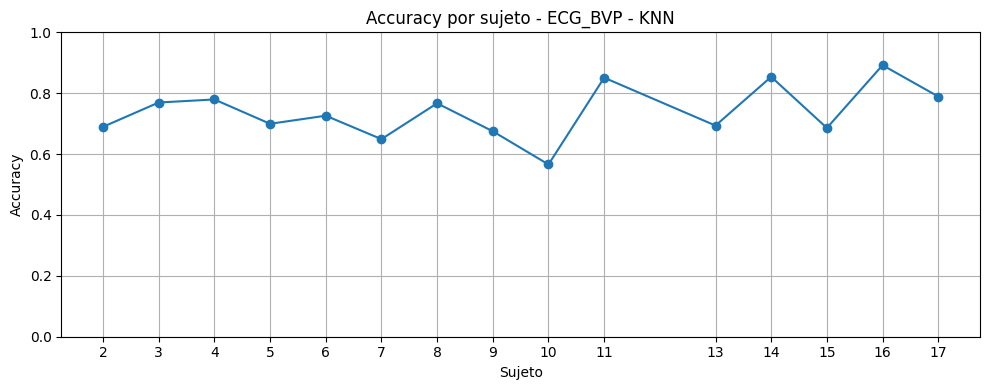

ECG_BVP - KNN Metrics
     Métrica     Valor          Etapa
0   Accuracy  0.739045  ECG_BVP - KNN
1  Precision  0.735736  ECG_BVP - KNN
2     Recall  0.739045  ECG_BVP - KNN
3   F1 Score  0.737240  ECG_BVP - KNN
[ECG_BVP - KNN] Best Params: {'n_neighbors': 9, 'weights': 'distance'}
[ECG_BVP - KNN] Accuracy: 0.7390
ECG_BVP - KNN - Confusion Matrix
[[74186 15932]
 [17737 21167]]


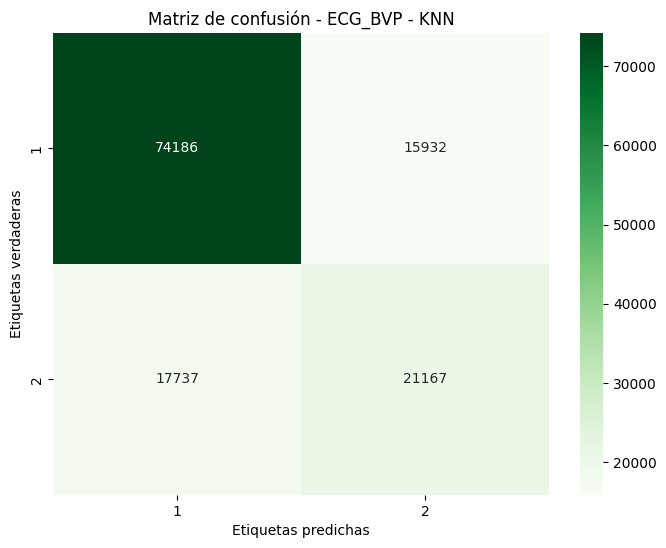

Training by signal:  20%|██        | 1/5 [22:52<1:31:31, 1372.98s/it]

              precision    recall  f1-score   support

           1       0.81      0.82      0.82     90118
           2       0.57      0.54      0.56     38904

    accuracy                           0.74    129022
   macro avg       0.69      0.68      0.69    129022
weighted avg       0.74      0.74      0.74    129022

Training DecisionTree model for EDA using LOGO...
[EDA - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EDA - DecisionTree] Fold 1/15 (Subject: 2)
[EDA - DecisionTree] Fold 2/15 (Subject: 3)
[EDA - DecisionTree] Fold 3/15 (Subject: 4)
[EDA - DecisionTree] Fold 4/15 (Subject: 5)
[EDA - DecisionTree] Fold 5/15 (Subject: 6)
[EDA - DecisionTree] Fold 6/15 (Subject: 7)
[EDA - DecisionTree] Fold 7/15 (Subject: 8)
[EDA - DecisionTree] Fold 8/15 (Subject: 9)
[EDA - DecisionTree] Fold 9/15 (Subject: 10)
[EDA - DecisionTree] Fold 10/15 (Subject: 11)
[EDA - DecisionTree] Fold 11/15 (Subject: 13)
[EDA - DecisionTree] F

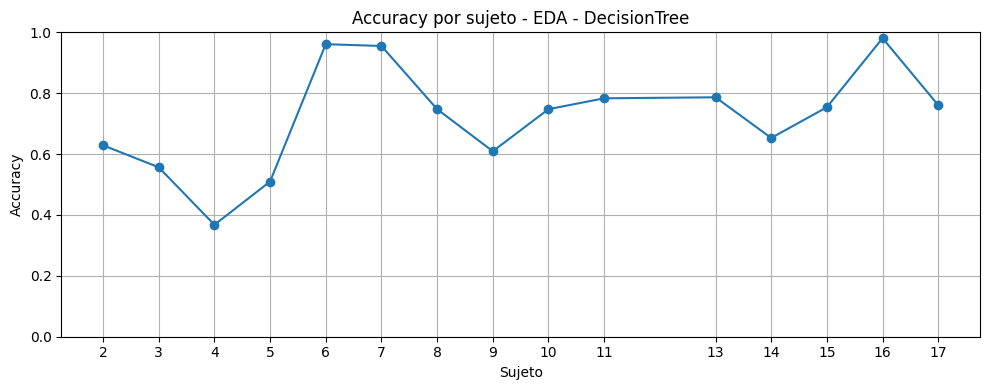

EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.721280  EDA - DecisionTree
1  Precision  0.729907  EDA - DecisionTree
2     Recall  0.721280  EDA - DecisionTree
3   F1 Score  0.724911  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {}
[EDA - DecisionTree] Accuracy: 0.7213
EDA - DecisionTree - Confusion Matrix
[[70150 19968]
 [15993 22911]]


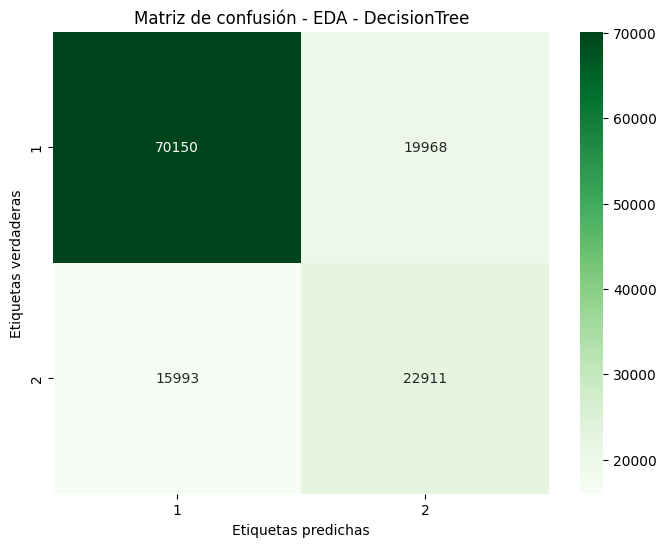

              precision    recall  f1-score   support

           1       0.81      0.78      0.80     90118
           2       0.53      0.59      0.56     38904

    accuracy                           0.72    129022
   macro avg       0.67      0.68      0.68    129022
weighted avg       0.73      0.72      0.72    129022

Training RandomForest model for EDA using LOGO...
[EDA - RandomForest] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits
[EDA - RandomForest] Fold 1/15 (Subject: 2)
[EDA - RandomForest] Fold 2/15 (Subject: 3)
[EDA - RandomForest] Fold 3/15 (Subject: 4)
[EDA - RandomForest] Fold 4/15 (Subject: 5)
[EDA - RandomForest] Fold 5/15 (Subject: 6)
[EDA - RandomForest] Fold 6/15 (Subject: 7)
[EDA - RandomForest] Fold 7/15 (Subject: 8)
[EDA - RandomForest] Fold 8/15 (Subject: 9)
[EDA - RandomForest] Fold 9/15 (Subject: 10)
[EDA - RandomForest] Fold 10/15 (Subject: 11)
[EDA - RandomForest] Fold 11/15 (Subject: 13)
[EDA - RandomForest] F

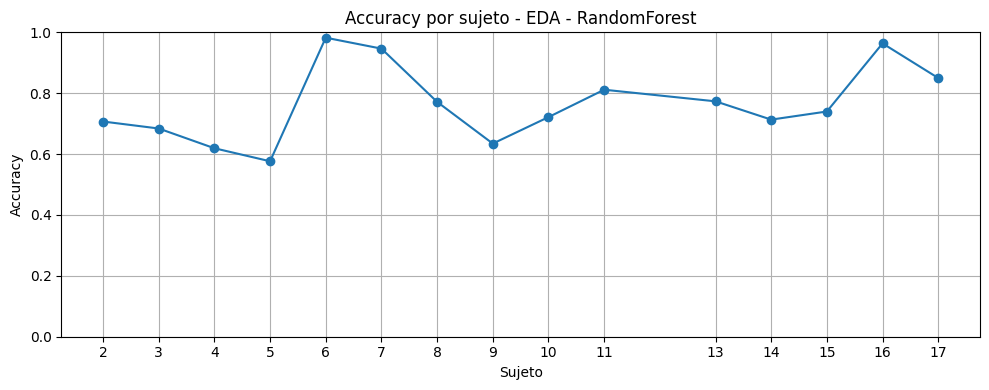

EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.766823  EDA - RandomForest
1  Precision  0.765837  EDA - RandomForest
2     Recall  0.766823  EDA - RandomForest
3   F1 Score  0.766313  EDA - RandomForest
[EDA - RandomForest] Best Params: {}
[EDA - RandomForest] Accuracy: 0.7668
EDA - RandomForest - Confusion Matrix
[[75370 14748]
 [15337 23567]]


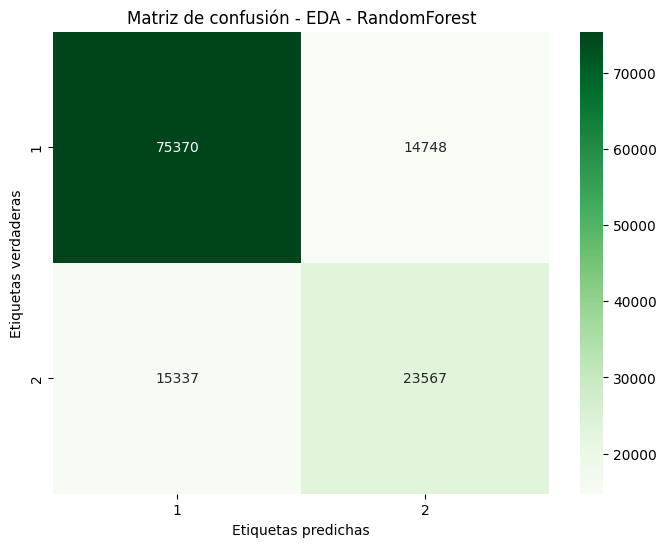

              precision    recall  f1-score   support

           1       0.83      0.84      0.83     90118
           2       0.62      0.61      0.61     38904

    accuracy                           0.77    129022
   macro avg       0.72      0.72      0.72    129022
weighted avg       0.77      0.77      0.77    129022

Training AdaBoost model for EDA using LOGO...
[EDA - AdaBoost] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 4 candidates, totalling 60 fits
[EDA - AdaBoost] Fold 1/15 (Subject: 2)
[EDA - AdaBoost] Fold 2/15 (Subject: 3)
[EDA - AdaBoost] Fold 3/15 (Subject: 4)
[EDA - AdaBoost] Fold 4/15 (Subject: 5)


In [ ]:
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features].values  # Convertimos a array
        y = df['label'].values
        subjects = df['subject'].values  # Identificador de sujetos

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal} using LOGO...')
            metrics = train_and_evaluate_logo(X, y, subjects, model, param_grid, model_name, signal)
            results[(signal, model_name)] = metrics.copy()

# Entrenamiento con todas las señales combinadas usando LOGO
X_all = df.drop(columns=['label', 'subject']).values
y_all = df['label'].values
subjects_all = df['subject'].values

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOGO...')
    metrics = train_and_evaluate_logo(X_all, y_all, subjects_all, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (signal, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo (LOSO)')
plt.tight_layout()
plt.show()


data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (signal, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((signal, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)  # <-- aquí el width más pequeño

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
file = r'WESAD_DATA_60_025\features.csv'

df = load_data(file)
df = df.fillna(0)

In [ ]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 68659
Label: 2 total: 38904
Label: 3 total: 21459


In [ ]:
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features].values  # Convertimos a array
        y = df['label'].values
        subjects = df['subject'].values  # Identificador de sujetos

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal} using LOGO...')
            metrics = train_and_evaluate_logo(X, y, subjects, model, param_grid, model_name, signal)
            results[(signal, model_name)] = metrics.copy()

# Entrenamiento con todas las señales combinadas usando LOGO
X_all = df.drop(columns=['label', 'subject']).values
y_all = df['label'].values
subjects_all = df['subject'].values

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOGO...')
    metrics = train_and_evaluate_logo(X_all, y_all, subjects_all, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (signal, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo (LOSO)')
plt.tight_layout()
plt.show()


data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (signal, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((signal, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)  # <-- aquí el width más pequeño

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

Training by signal:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ECG_BVP using LOGO...
[ECG_BVP - DecisionTree] LOGO: 15 folds (1 por sujeto)
Fitting 15 folds for each of 1 candidates, totalling 15 fits


Training by signal:   0%|          | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 